In [1]:
!CUDA_VISIBLE_DEVICE=2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

UMAP

In [3]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='cuda',
        seed=0,
        hparams="",
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_all/model_seed=0_step=800000.pt')) # replace with your own AE
    return autoencoder

real data

In [21]:
adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad')

adata = adata[np.where(adata.obs['celltype'].values.isnull()==0)[0]][::3]

sc.pp.normalize_total(adata, target_sum=1e4)

gene_names = adata.var_names

celltype = adata.obs['celltype']
cell_data = adata.X.toarray()
cell_data.shape

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(19002, 18996)

generated data

In [9]:
npzfile=np.load('/data1/lep/Workspace/guided-diffusion/data/new_version/muris_all.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][::3]

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

ori = ad.AnnData(cell_gen_all, dtype=np.float32)

cell_gen = ori.X
# add this threadhold if sc.pp.neighbors encounter Input contains NaN.
cell_gen = cell_gen*(cell_gen>0.0001)

cell_gen.shape

(57000, 18996)

conditional generated data & gradient interpolation data

In [22]:
cell_gen_all = []
gen_class = []

cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
index = ['0','1','2','3','4','5','6','7','8','9','10','11']

for i in range(len(index)):
    npzfile=np.load('../data/new_version/muris_all3_'+index[i]+'.npz',allow_pickle=True)
    lenght = adata[adata.obs['celltype']==cato[i]].shape[0]
    cell_gen_all.append(npzfile['cell_gen'][:int(lenght/2)])#.squeeze(1)
    gen_class+=['gen '+cato[i]]*int(lenght/2)

cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

ori = ad.AnnData(cell_gen_all, dtype=np.float32)

ori.obs['celltype'] = gen_class

cell_gen = ori.X
# add this threadhold if sc.pp.neighbors encounter Input contains NaN.
cell_gen = cell_gen*(cell_gen>0.0001)

gen_class = ori.obs['celltype']
cell_gen.shape

(9498, 18996)

plot UMAP

In [23]:
real_adata = ad.AnnData(cell_data, dtype=np.float32)
gen_adata = ad.AnnData(cell_gen, dtype=np.float32)
real_adata.var_names = gene_names
gen_adata.var_names = gene_names

sc.pp.log1p(real_adata)
sc.pp.highly_variable_genes(real_adata)
gen_adata = gen_adata[:,real_adata.var['highly_variable']]
real_adata = real_adata[:, real_adata.var.highly_variable]
sc.pp.scale(real_adata)

sc.pp.log1p(gen_adata)
sc.pp.scale(gen_adata)
sc.tl.pca(real_adata, svd_solver='arpack')

X_pca = np.dot(gen_adata.X, real_adata.varm['PCs'])
gen_adata.obsm['X_pca'] = X_pca

adata = sc.concat((real_adata,gen_adata))

try:
    adata.obs['celltype'] = np.concatenate((celltype, gen_class))
except:
    adata.obs['celltype'] = np.concatenate((celltype, ['generated']*gen_adata.X.shape[0]))

adata.obs['cell_name'] = [f"Generated Cell" for i in range(cell_data.shape[0])]+[f"Real Cell" for i in range(cell_gen.shape[0])]
adata

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 28500 × 2622
    obs: 'celltype', 'cell_name'
    obsm: 'X_pca'

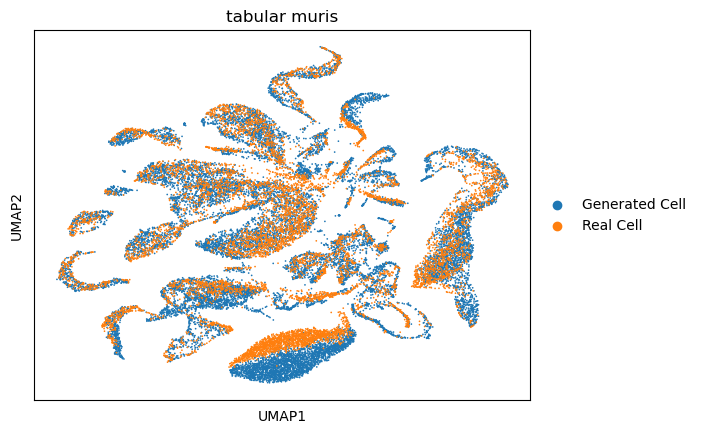

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='tabular muris')

draw plot of each cell type if conditional generation

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/sc

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/sc

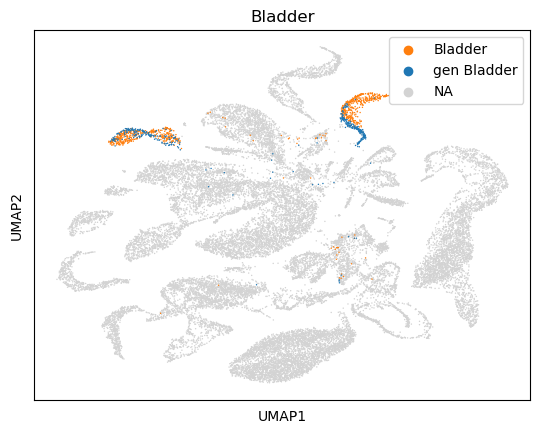

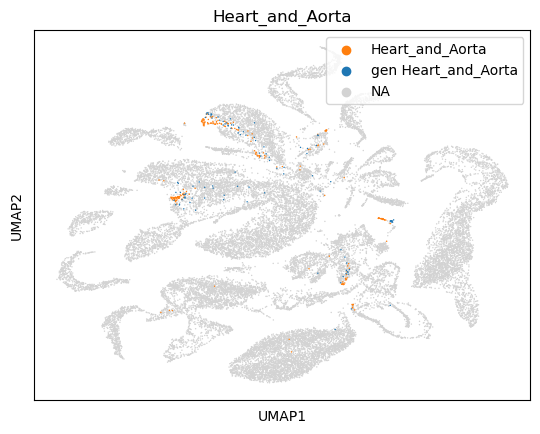

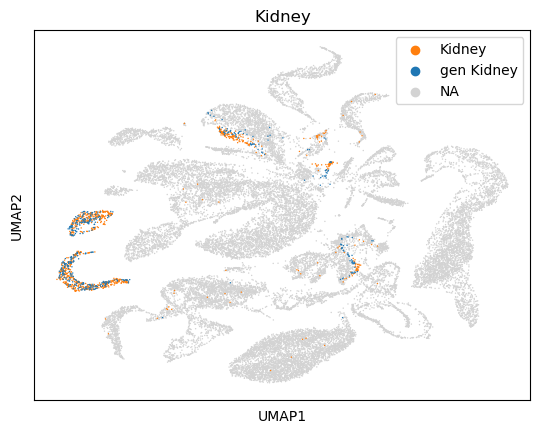

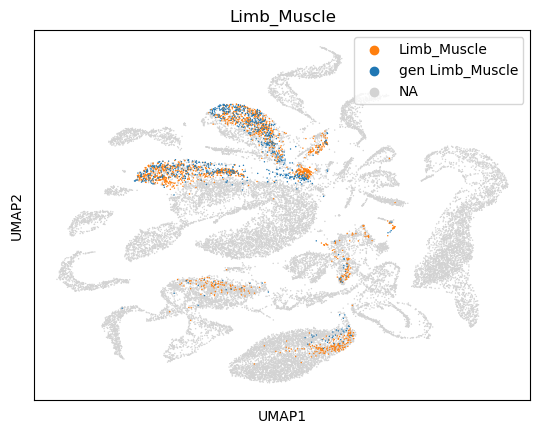

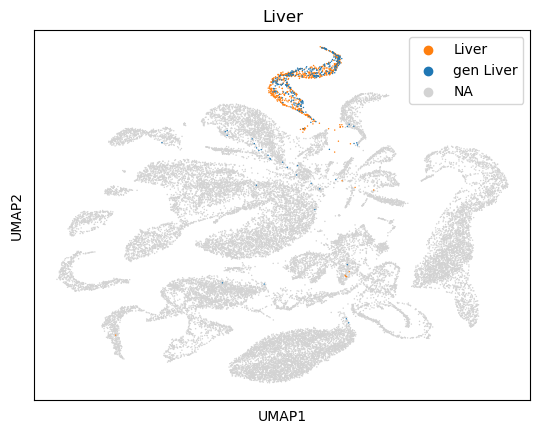

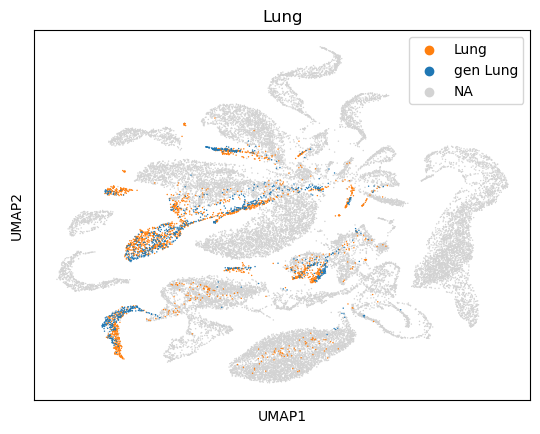

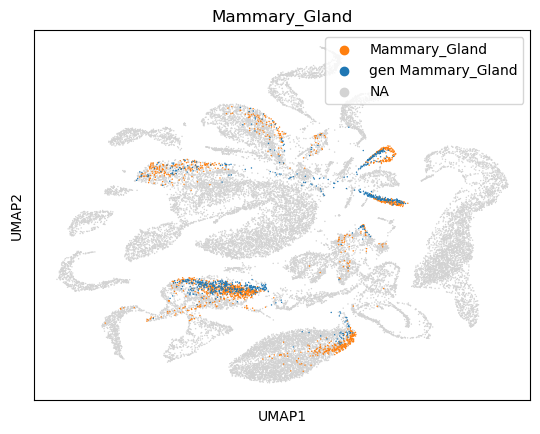

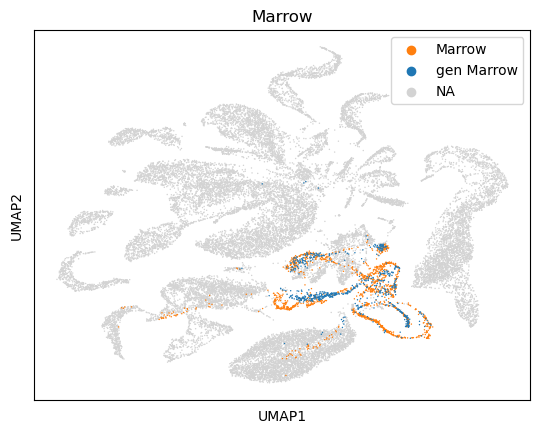

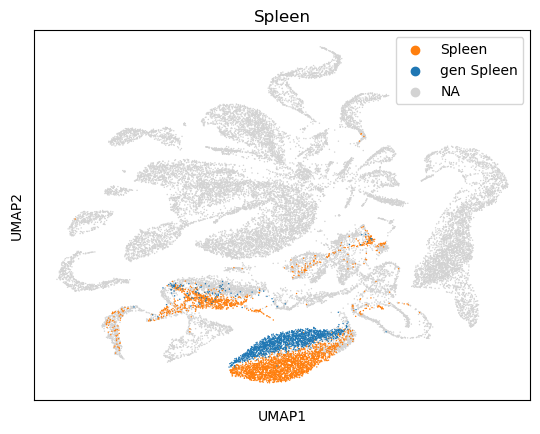

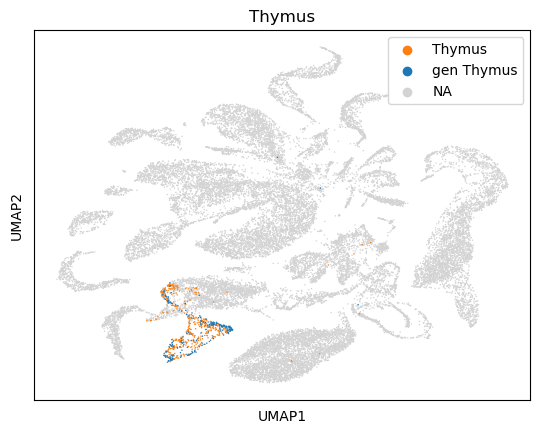

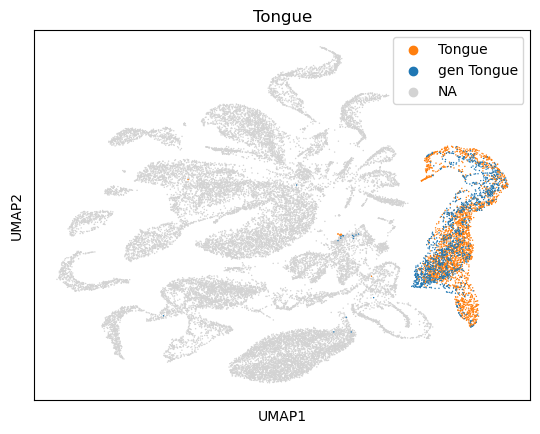

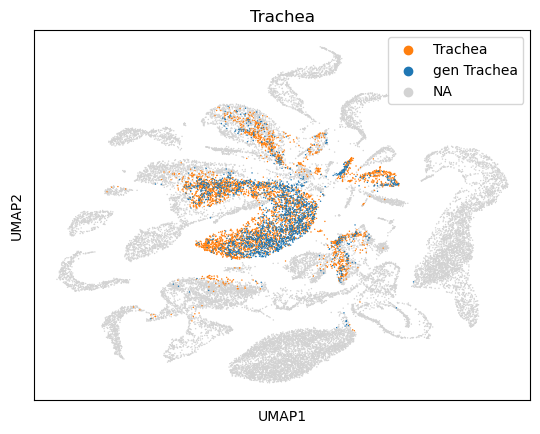

: 

In [25]:
for categoray in cato:
    color_dict = {}
    for cat in adata.obs['celltype'].cat.categories:
        if cat == categoray:
            color_dict[cat] = 'tab:orange'
        elif cat == 'gen '+categoray:
            color_dict[cat] = 'tab:blue'
        else:
            color_dict[cat] = 'black'
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    sc.pl.umap(adata=adata,color="celltype",groups=[categoray,'gen '+categoray], palette=color_dict, show = False)
    plt.legend(loc = 'upper right')
    plt.title(categoray)